# **__O Problema__**

Você é um profissional encarregado de desenvolver um modelo preditivo de regressão para prever o valor dos custos médicos individuais cobrados pelo seguro de saúde.


A base de dados para este desafio será a seguinte:

https://github.com/feliperaro/fiap-pos-tech/blob/main/tech-challenge-1/resources/datasets/insurance.csv


Neste notebook, vamos explorar e preparar os dados, treinar diferentes modelos de machine learning e, finalmente, avaliar qual modelo oferece a melhor precisão para prever o valor dos custos médicos.


# Importação de Bibliotecas
Para iniciar, instalamos e importamos as bibliotecas necessárias para manipulação de dados, visualização e construção dos modelos de machine learning.


In [1]:
# !conda install scikit-learn matplotlib numpy pandas seaborn -y
# !pip install scikit-learn matplotlib numpy pandas seaborn -y


In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import seaborn as sns



# Carregamento de Dados
Download e leitura do dataset.



In [3]:
def download_dataset():
    url = "https://raw.githubusercontent.com/feliperaro/fiap-pos-tech/refs/heads/main/tech-challenge-1/resources/datasets/insurance.csv"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to download file. Status code: {response.status_code}")
        return None

    with open("dataset.csv", "wb") as file:
        file.write(response.content)

download_dataset()
dataset = pd.read_csv("dataset.csv")



# Análise Exploratória dos Dados (EDA)
Nesta seção, exploramos as variáveis do dataset e analisamos suas distribuições.


In [4]:
dataset.shape

(1338, 7)

In [5]:
dataset.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
dataset.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [7]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [8]:
dataset.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [9]:
dataset.duplicated().value_counts()

False    1337
True        1
Name: count, dtype: int64

In [10]:
dataset.drop_duplicates(inplace=True)

In [11]:
string_columns = ["sex", "smoker", "region"]
for col in string_columns:
    print(f"{col}: {dataset[col].unique()}")


sex: ['female' 'male']
smoker: ['yes' 'no']
region: ['southwest' 'southeast' 'northwest' 'northeast']


In [12]:
data_to_translate = {
    "columns": {
        "age": "idade",
        "sex": "genero",
        "bmi": "imc",
        "children": "filhos",
        "smoker": "fumante",
        "region": "regiao",
        "charges": "custos"
    },
    "values": {
        "male": "masculino",
        "female": "feminino",
        "yes": "sim",
        "no": "nao",
        "northeast": "nordeste",
        "northwest": "noroeste",
        "southeast": "sudeste",
        "southwest": "sudoeste"
    }
}

for key, value in data_to_translate.items():
    if key == "columns":
        dataset = dataset.rename(columns=value)
    elif key == "values":
        dataset = dataset.replace(value)
...
dataset.head()

,idade,genero,imc,filhos,fumante,regiao,custos
0,19,feminino,27.900,0,sim,sudoeste,16884.92400
1,18,masculino,33.770,1,nao,sudeste,1725.55230
2,28,masculino,33.000,3,nao,sudeste,4449.46200
3,33,masculino,22.705,0,nao,noroeste,21984.47061
4,32,masculino,28.880,0,nao,noroeste,3866.85520


In [13]:
dataset.describe()

,idade,imc,filhos,custos
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


array([[<Axes: title={'center': 'idade'}>,
        <Axes: title={'center': 'imc'}>],
       [<Axes: title={'center': 'filhos'}>,
        <Axes: title={'center': 'custos'}>]], dtype=object)

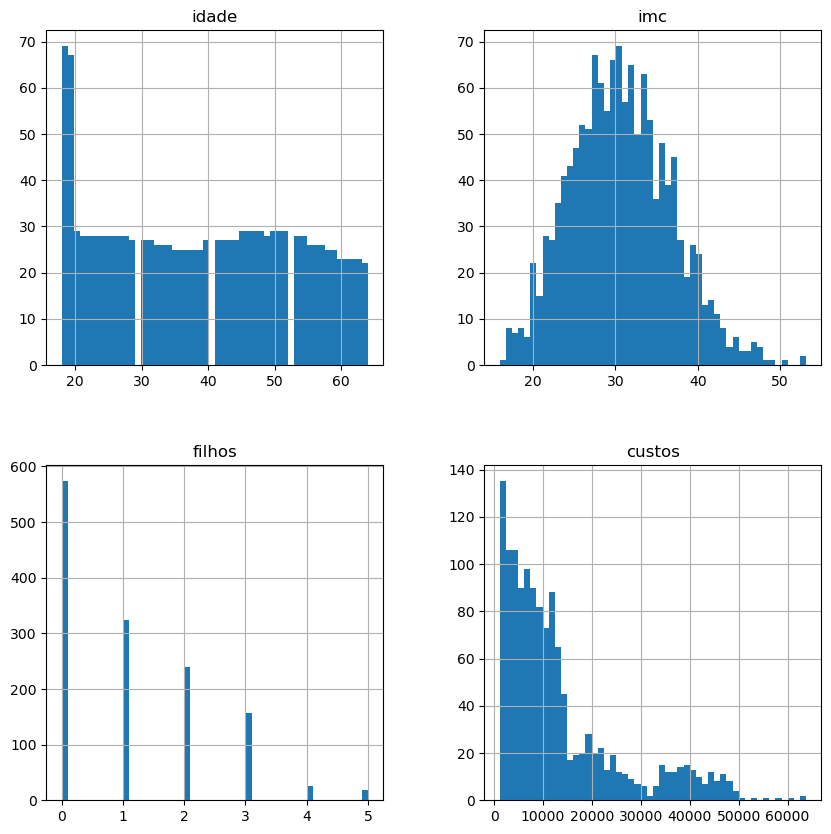

In [14]:
dataset.hist(bins=50, figsize=(10, 10))

grupo_idade
Jovem         10094.281885
Meia-Idade    13744.285794
Sênior        17902.552070
Name: custos, dtype: float64


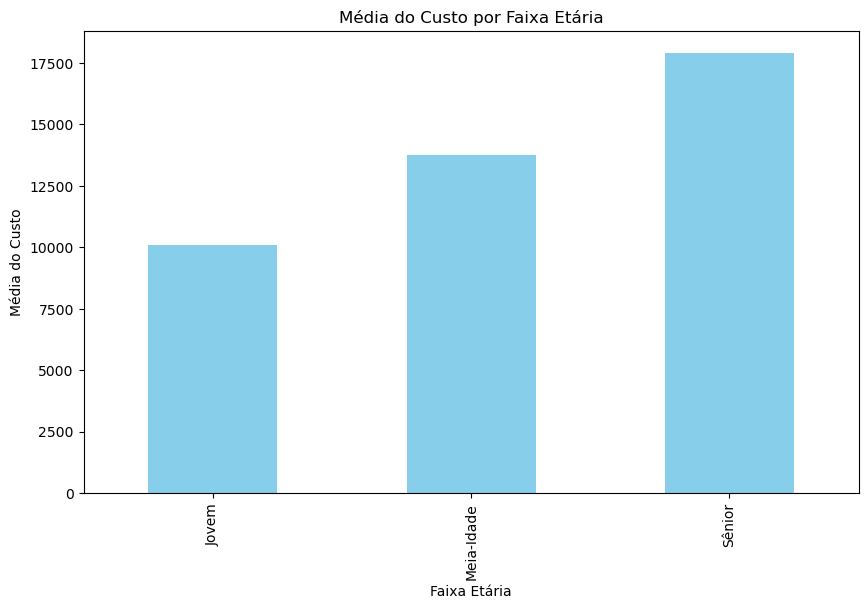

In [15]:
dataset['grupo_idade'] = pd.cut(
    dataset['idade'], 
    bins=[20, 35, 50, 65],  # Intervalos para as faixas
    labels=['Jovem', 'Meia-Idade', 'Sênior'],  # Rótulos para cada faixa
    right=False  # Inclui o limite inferior em cada faixa
)

age_cost_mean = dataset.groupby('grupo_idade', observed=True)['custos'].mean()

print(age_cost_mean)
age_cost_mean.plot(kind='bar', figsize=(10, 6), color='skyblue')

plt.title("Média do Custo por Faixa Etária")
plt.xlabel("Faixa Etária")
plt.ylabel("Média do Custo")
plt.show()


In [16]:
colunas = ["genero", "fumante", "regiao", "idade", "imc"]

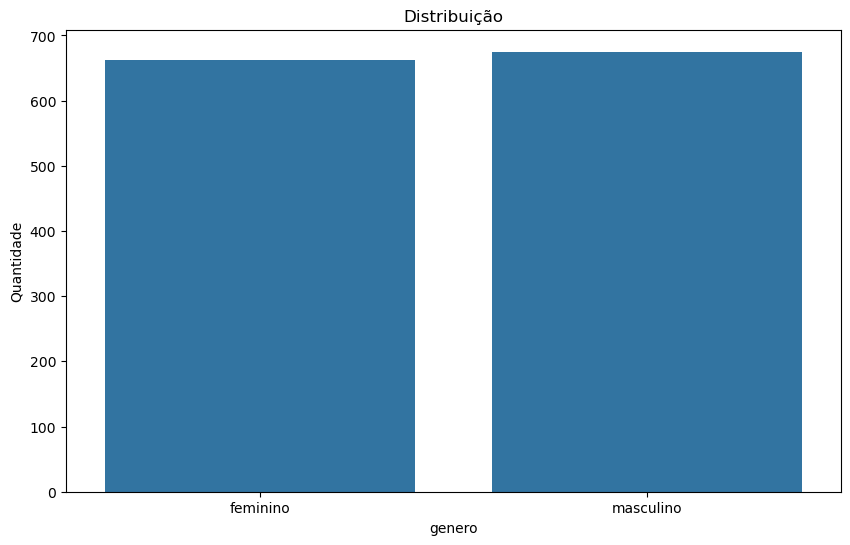

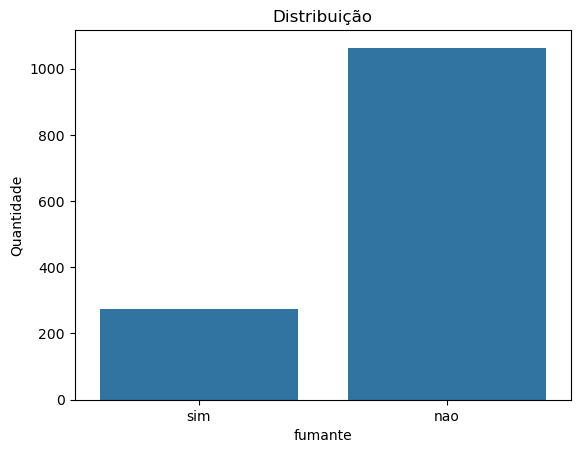

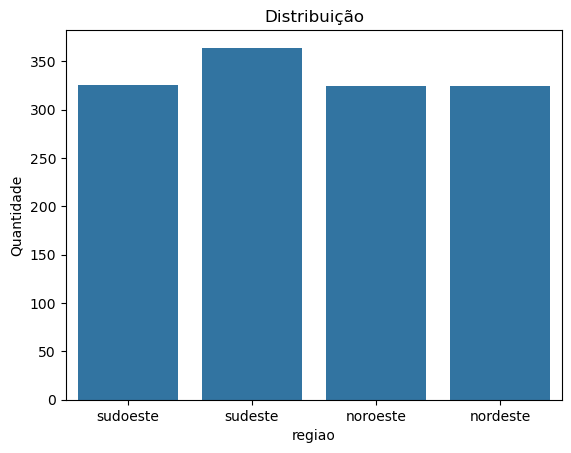

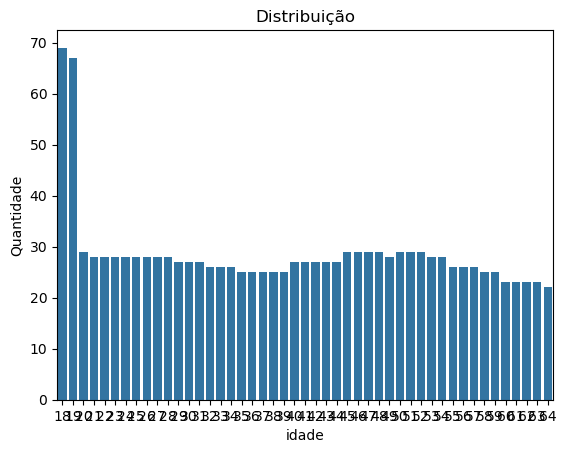

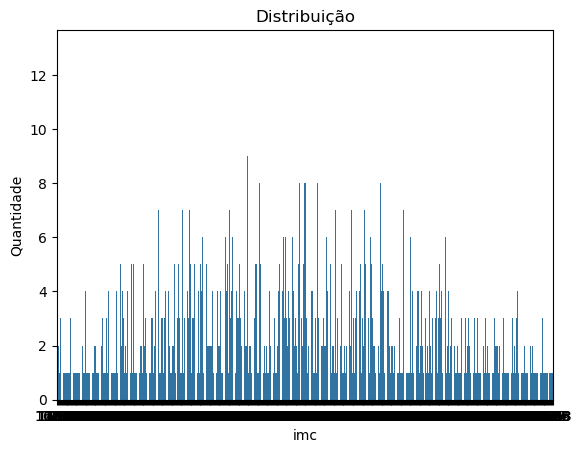

In [17]:
plt.figure(figsize=(10, 6))
for coluna in colunas:
    sns.countplot(x=coluna, data=dataset, legend=False)
    plt.title('Distribuição')

    plt.xlabel(coluna)
    plt.ylabel("Quantidade")

    plt.show()


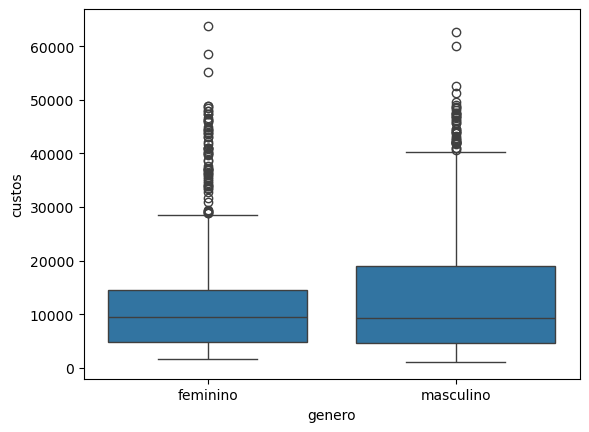

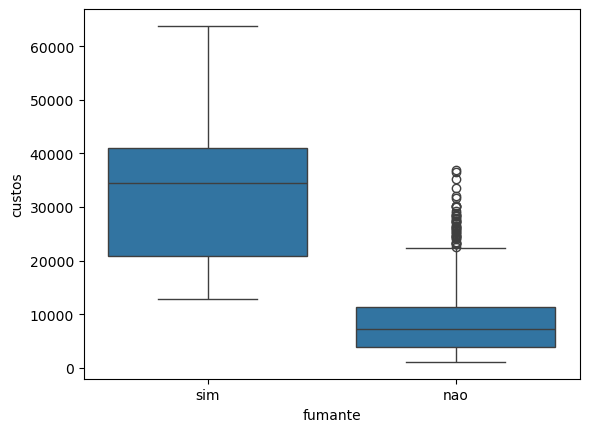

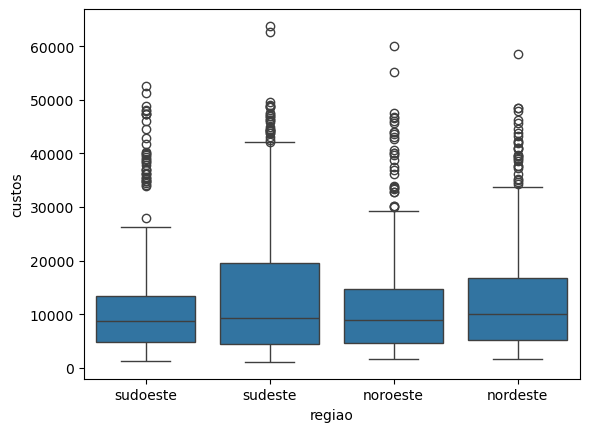

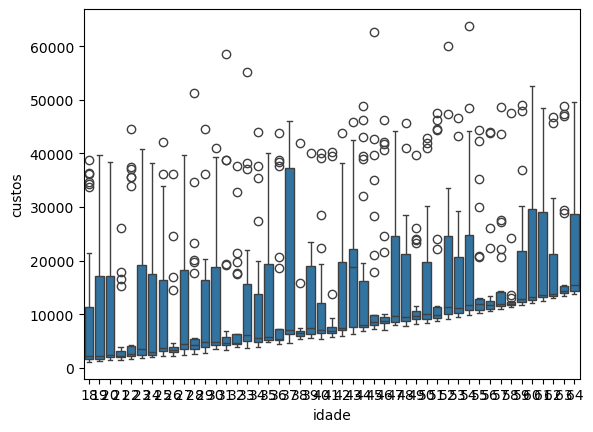

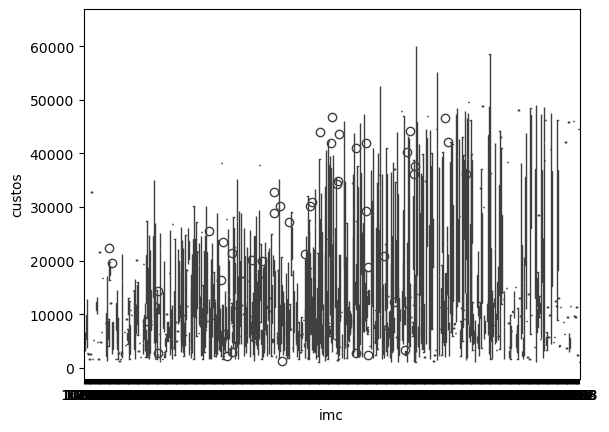

In [18]:
for column in colunas:
    sns.boxplot(x=column, y='custos', data=dataset)
    plt.show()


# Preparação dos Dados


In [19]:
dataset = pd.get_dummies(dataset, drop_first=True)
dataset.columns

Index(['idade', 'imc', 'filhos', 'custos', 'genero_masculino', 'fumante_sim',
       'regiao_noroeste', 'regiao_sudeste', 'regiao_sudoeste',
       'grupo_idade_Meia-Idade', 'grupo_idade_Sênior'],
      dtype='object')

In [20]:
X = dataset.drop('custos', axis=1)
y = dataset['custos']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)
predicts = model.predict(X_test)


# Detecção e Remoção de Outliers

Outliers são valores que estão fora do padrão esperado e podem distorcer a análise e o desempenho dos modelos de machine learning. Nesta etapa, vamos identificar e remover esses valores para obter um conjunto de dados mais limpo e representativo usando o IQR (Intervalo Interquartil) para melhorar a qualidade dos dados.

1. **Calcular o IQR (Intervalo Interquartil)**: 
   - Calculamos o primeiro quartil (Q1 == 25%) e o terceiro quartil (Q3 == 75%) de cada variável numérica. A diferença entre eles (Q3 - Q1) é o IQR, que representa a dispersão central dos dados.

2. **Definir Limites para Outliers**: 
   - Usamos a regra comum para detectar outliers, considerando como "fora do padrão" os valores que estão abaixo de `25%` ou acima de `75%`.
   


**remove_outliers()**: 
   - Cria uma máscara (filtro) para manter apenas as linhas com valores dentro dos limites normais, removendo linhas que possuem outliers em alguma variável numérica.

In [21]:
def remove_outliers(df, features):
    mask = True
    for feature in features:
        mask &= (
            df[feature] >= (Q1[feature] - 1.5 * IQR[feature])) & (df[feature] <= (Q3[feature] + 1.5 * IQR[feature])
        )
    return df[mask]



In [22]:
features_numericas = dataset.select_dtypes(include=['float64', 'int64']).columns
print("features_numericas:", features_numericas)

Q1 = dataset[features_numericas].quantile(0.25)
Q3 = dataset[features_numericas].quantile(0.75)

IQR = Q3 - Q1
print("Tamanho do DataFrame Original:", dataset.shape)

dataset_limpo = remove_outliers(dataset, features_numericas)
print("dataset_limpo.shape:", dataset_limpo.shape)


features_numericas: Index(['idade', 'imc', 'filhos', 'custos'], dtype='object')
Tamanho do DataFrame Original: (1337, 11)
dataset_limpo.shape: (1192, 11)


In [23]:
X = dataset_limpo.drop('custos', axis=1)
y = dataset_limpo['custos']

X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

model = LinearRegression()
model.fit(X_train_cleaned, y_train_cleaned)
predicts_cleaned = model.predict(X_test_cleaned)


In [24]:
mae_original = mean_absolute_error(y_test, predicts)
mse_original = mean_squared_error(y_test, predicts)

mae_cleaned = mean_absolute_error(y_test_cleaned, predicts_cleaned)
mse_cleaned = mean_squared_error(y_test_cleaned, predicts_cleaned)

print(f"Desempenho no dataset original - MAE: {mae_original}, MSE: {mse_original}")
print(f"Desempenho no dataset limpo - MAE: {mae_cleaned}, MSE: {mse_cleaned}")

Desempenho no dataset original - MAE: 4197.437978777144, MSE: 35646216.816224314
Desempenho no dataset limpo - MAE: 2725.3732605418004, MSE: 23314568.581056897


In [25]:
dataset = dataset_limpo

X = dataset.drop('custos', axis=1)
y = dataset['custos']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
}

results = {}
for model_name, model in models.items():
    cv_mse_scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=5,
        scoring='neg_mean_squared_error'
    )
    
    cv_mae_scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=5,
        scoring='neg_mean_absolute_error'
    )

    results[model_name] = {
        "Mean MSE (CV)": -cv_mse_scores.mean(),
        "MSE Scores (CV)": -cv_mse_scores,
        "Mean MAE (CV)": -cv_mae_scores.mean(),
        "MAE Scores (CV)": -cv_mae_scores
    }
    model.fit(X_train, y_train)

In [26]:
for model_name, metrics in results.items():
    mse_scores = metrics['MSE Scores (CV)']
    mae_scores = metrics['MAE Scores (CV)']
    
    print(f"{model_name}:")
    print(f"Mean MSE (CV): {metrics['Mean MSE (CV)']:.2f}")
    print(f"MSE Scores (CV): {mse_scores}")
    print(f"Mean MAE (CV): {metrics['Mean MAE (CV)']:.2f}")
    print(f"MAE Scores (CV): {mae_scores}\n")


Linear Regression:
Mean MSE (CV): 20213311.50
MSE Scores (CV): [18859866.14391359 19814906.97151728 16407944.13892958 19374620.50631966
 26609219.74381296]
Mean MAE (CV): 2453.99
MAE Scores (CV): [2409.68090428 2532.98051393 2222.28081684 2483.79182901 2621.23706533]

Decision Tree:
Mean MSE (CV): 44218593.75
MSE Scores (CV): [45879016.28623182 40675527.43210425 51221848.15547851 38242281.36835109
 45074295.50211519]
Mean MAE (CV): 3143.36
MAE Scores (CV): [3131.6474423  3228.17763455 3308.12463754 2864.34928521 3184.51269742]

Random Forest:
Mean MSE (CV): 22303387.71
MSE Scores (CV): [21199211.64364318 21115562.54028856 19328380.03249369 21029808.03876426
 28843976.2963947 ]
Mean MAE (CV): 2613.46
MAE Scores (CV): [2554.70366546 2556.37313879 2583.88213456 2571.79942621 2800.56634184]



## Comparação de Modelos

Comparação dos três modelos – **Regressão Linear**, **Árvore de Decisão** e **Random Forest** – usando validação cruzada para avaliar o desempenho de cada um com as métricas **Mean Squared Error (MSE)** e **Mean Absolute Error (MAE)**.

### Conclusão

O **Random Forest** foi o modelo que apresentou o melhor desempenho geral, com o menor **Mean MSE** e **Mean MAE** entre os três modelos avaliados. Isso significa que o Random Forest:
- Possui menor variabilidade nas previsões, refletido pelo MSE mais baixo.
- Faz previsões mais próximas dos valores reais, indicado pelo menor MAE.

Portanto, com base nos resultados, o **Random Forest** é a melhor escolha para prever os custos médicos, oferecendo uma combinação equilibrada entre precisão e robustez para lidar com as variáveis deste dataset.


Linear Regression: MSE = 23314568.58, R² = 0.60
Decision Tree: MSE = 40312201.11, R² = 0.31
Random Forest: MSE = 22846274.62, R² = 0.61


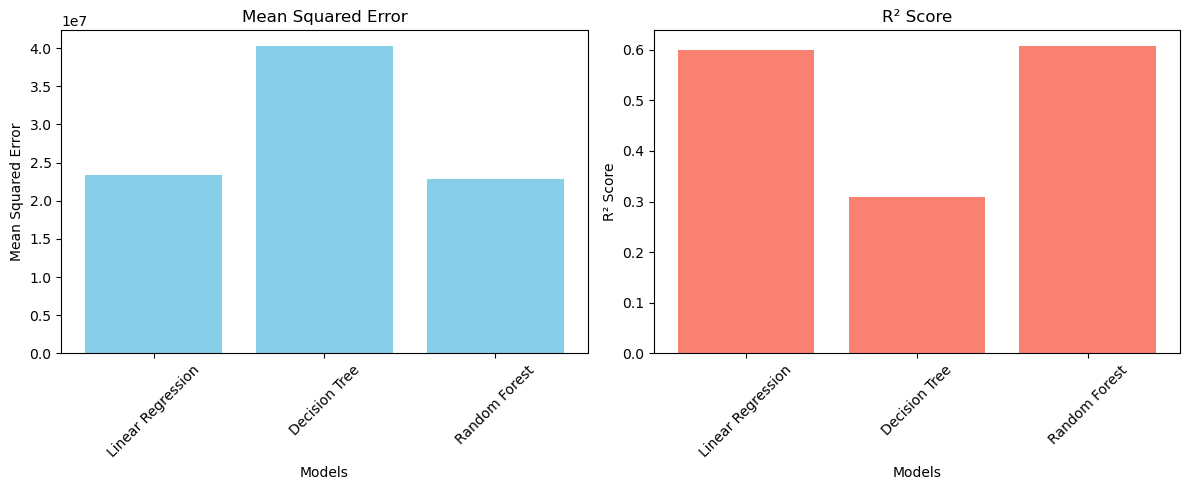

In [27]:
evaluation_results = {}
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    evaluation_results[model_name] = {
        "Mean Squared Error": mse,
        "R² Score": r2
    }

for model_name, metrics in evaluation_results.items():
    print(f"{model_name}: MSE = {metrics['Mean Squared Error']:.2f}, R² = {metrics['R² Score']:.2f}")

model_names = list(evaluation_results.keys())
mse_values = [metrics['Mean Squared Error'] for metrics in evaluation_results.values()]
r2_values = [metrics['R² Score'] for metrics in evaluation_results.values()]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(model_names, mse_values, color='skyblue')
plt.title('Mean Squared Error')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(model_names, r2_values, color='salmon')
plt.title('R² Score')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [28]:
best_model = RandomForestRegressor(random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)
print(f"Best Model MSE: {mse:.4f}, R² Score: {r2:.4f}")


Best Model MSE: 22846274.6206, R² Score: 0.6079


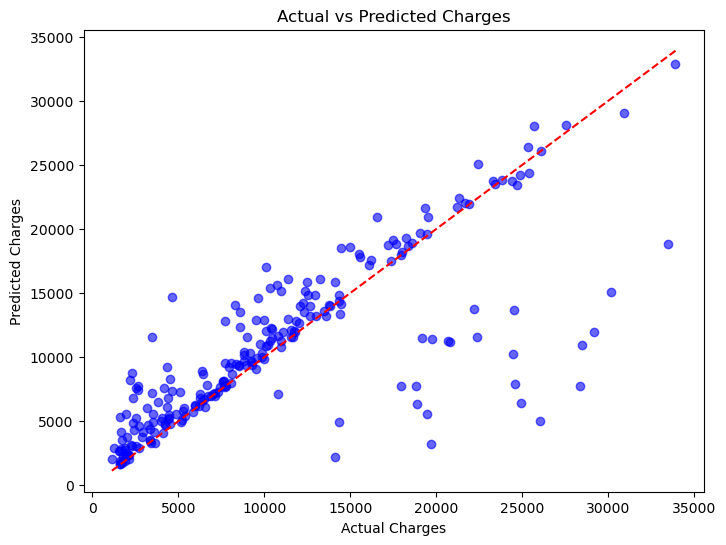

In [29]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges')
plt.show()

# Próximos Passos

Após a análise e comparação dos modelos, identificamos que o **Random Forest** apresentou o melhor desempenho geral na previsão dos custos médicos, tanto antes quanto depois da remoção dos outliers. A seguir, listamos algumas sugestões de próximos passos para aprimorar ainda mais o modelo e o processo de análise:

### 1. Testar Outros Modelos de Machine Learning
   - Experimentar modelos mais complexos, como **Gradient Boosting** ou **XGBoost**, que frequentemente têm um bom desempenho em problemas de regressão e podem capturar padrões mais sutis nos dados.
   - Avaliar o desempenho desses modelos comparado ao Random Forest para garantir que temos a melhor escolha.

### 2. Feature Engineering
   - Explorar novas combinações de variáveis (features), como **interações entre variáveis** ou **transformações logarítmicas**, que possam capturar melhor a relação entre variáveis e custos.
   - A criação de variáveis derivadas pode ajudar o modelo a entender padrões ocultos nos dados, especialmente se houver relações não lineares.

### 3. Implementação em Produção
   - Desenvolver um **pipeline de produção** para implementar o modelo, permitindo que ele faça previsões em tempo real.
   - Esse pipeline pode incluir a preparação dos dados (limpeza e transformação), aplicação do modelo treinado e armazenamento das previsões.
   - Monitorar o desempenho do modelo ao longo do tempo para ajustar caso haja mudanças nos dados ou nas condições do problema.

### 4. Monitoramento e Atualização do Modelo
   - Estabelecer um sistema de **monitoramento contínuo** para acompanhar o desempenho do modelo ao longo do tempo e detectar possíveis drifts de dados, que podem ocorrer se o perfil dos dados mudar.
   - Realizar re-treinamento periódico para atualizar o modelo com novos dados, garantindo que ele permaneça preciso e relevante.

Esses próximos passos ajudarão a garantir que o modelo seja robusto, confiável e eficiente em um cenário de produção, além de permitir um monitoramento e uma evolução contínua conforme o problema e os dados mudam.
